## Importando bibliotecas

In [1]:
import pandas as pd
import glob
import os
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='whitegrid')
import sys
from util import *
import gc
import pickle

import warnings

# Ignorar todos os warnings
warnings.filterwarnings("ignore")

C:\Users\Jean\Documents\projetos\recomendacao_produtos\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Lendo os dados

In [4]:
base_compras = pd.read_csv("../data/raw/base_compras.csv")
base_departamentos = pd.read_csv("../data/raw/base_departamentos.csv")
base_produtos = pd.read_csv("../data/raw/base_produtos.csv")
base_tipo_produto = pd.read_csv("../data/raw/base_tipo_de_produto.csv")

## Join dos dados

In [22]:
base01 = pd.merge(base_compras, base_produtos, how='left', on='product_id')
base02 = pd.merge(base01, base_departamentos, how='left', on='department_id')
base03 = pd.merge(base02, base_tipo_produto, how='left', on='aisle_id')

In [23]:
base03 = base03.drop(columns=['aisle_id', 'department_id'])
display(base03.head())

,product_id,user_id,order_dow,order_hour_of_day,product_name,department,aisle
0,196,1,1,9,Soda,beverages,soft drinks
1,12427,1,1,9,Original Beef Jerky,snacks,popcorn jerky
2,48110,2,2,11,Thin Stackers Brown Rice Lightly Salted,snacks,crackers
3,22474,2,2,11,Cheddar Bunnies Snack Crackers,snacks,crackers
4,16589,2,2,11,Plantain Chips,snacks,chips pretzels


## Entendimento dos dados

In [16]:
print(base03.shape)


(5262584, 7)


In [20]:
metadados_compras = generate_metadata(df=base03, ids=['product_id', 'user_id'],targets=[''], orderby='CARDINALIDADE')
display(metadados_compras)

,FEATURE,USO_FEATURE,QT_NULOS,PC_NULOS,CARDINALIDADE,TIPO_FEATURE
0,user_id,ID,0,0.0,201895,int64
1,product_id,ID,0,0.0,43318,int64
2,product_name,Explicativa,0,0.0,43318,object
3,aisle,Explicativa,0,0.0,119,object
4,order_hour_of_day,Explicativa,0,0.0,24,int64
5,department,Explicativa,0,0.0,19,object
6,order_dow,Explicativa,0,0.0,7,int64


## Análises Solicitadas

### Distribuição de vendas
i. Por Departamento de produtos

Distribuição por Departamento (%):


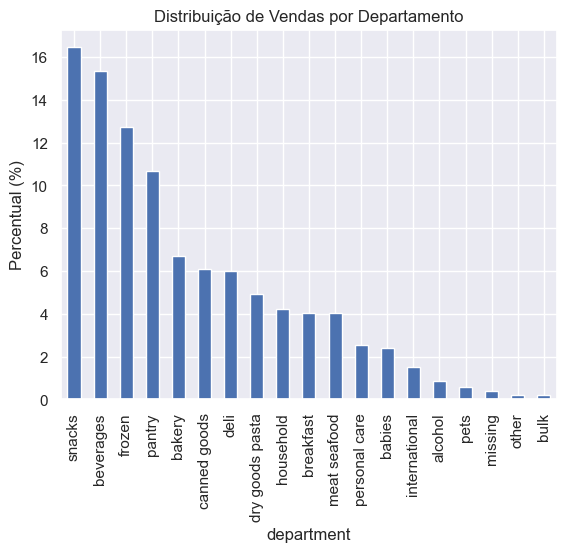

In [25]:
# Distribuição por departamento
dist_departamento = base03['department'].value_counts(normalize=True) * 100
print("Distribuição por Departamento (%):")

# Visualização
import matplotlib.pyplot as plt
dist_departamento.plot(kind='bar', title='Distribuição de Vendas por Departamento')
plt.ylabel('Percentual (%)')
plt.show()

### Distribuição de vendas
ii. Por Dia de semana


Distribuição por Dia da Semana (%):


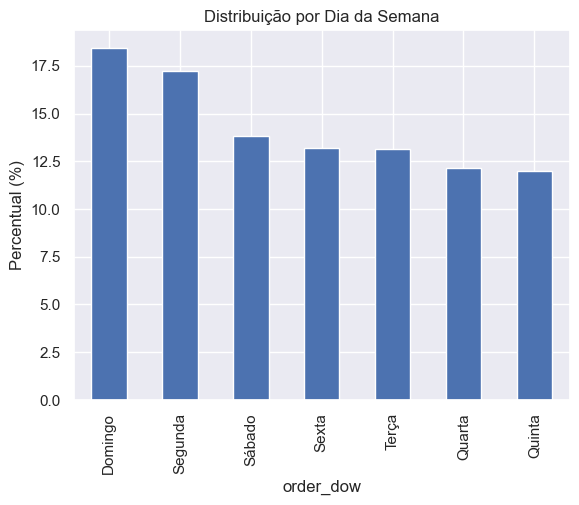

In [26]:
# Distribuição por dia da semana
dist_dia_semana = base03['order_dow'].value_counts(normalize=True) * 100
print("\nDistribuição por Dia da Semana (%):")

# Mapear números para nomes dos dias (se necessário)
dias = {0: 'Domingo', 1: 'Segunda', 2: 'Terça', 3: 'Quarta',
        4: 'Quinta', 5: 'Sexta', 6: 'Sábado'}
dist_dia_semana.index = dist_dia_semana.index.map(dias)
dist_dia_semana.plot(kind='bar', title='Distribuição por Dia da Semana')
plt.ylabel('Percentual (%)')
plt.show()

### Distribuição de vendas
iii. Por Hora do dia


Distribuição por Hora do Dia (%):


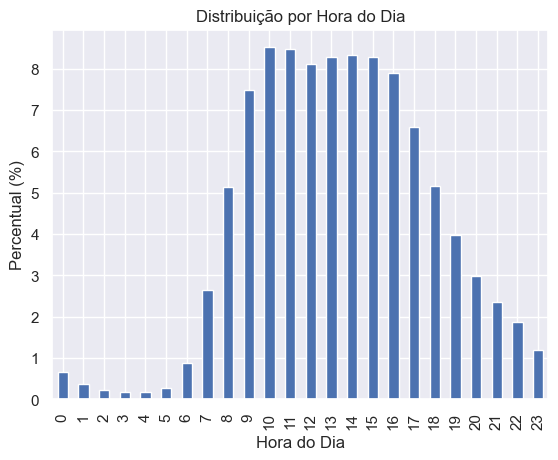

In [27]:
# Distribuição por hora do dia
dist_hora = base03['order_hour_of_day'].value_counts(normalize=True) * 100
print("\nDistribuição por Hora do Dia (%):")

# Visualização
dist_hora.sort_index().plot(kind='bar', title='Distribuição por Hora do Dia')
plt.ylabel('Percentual (%)')
plt.xlabel('Hora do Dia')
plt.show()

### Ranking TOP 5 Produtos mais vendidos por departamento

In [35]:
# Versão com pivot_table para visualização
pivot = (
    base03.pivot_table(
        index=['department', 'product_name'],
        aggfunc='size',
        fill_value=0
    )
    .rename('count')
    .reset_index()
)

# Calculando top 5
top5_por_departamento = (
    pivot.groupby('department')
    .apply(lambda x: x.nlargest(5, 'count'))
    .reset_index(drop=True)
)

# Calculando frequências
top5_por_departamento['freq_relativa'] = (
    top5_por_departamento.groupby('department')['count']
    .transform(lambda x: (x / x.sum() * 100).round(2))
)

top5_por_departamento['freq_acumulada'] = (
    top5_por_departamento.groupby('department')['freq_relativa']
    .cumsum().round(2)
)

display(top5_por_departamento)

,department,product_name,count,freq_relativa,freq_acumulada
0,alcohol,Sauvignon Blanc,2466,26.10,26.10
1,alcohol,Cabernet Sauvignon,1842,19.50,45.60
2,alcohol,Chardonnay,1812,19.18,64.78
3,alcohol,Beer,1689,17.88,82.66
4,alcohol,Vodka,1638,17.34,100.00
...,...,...,...,...,...
90,snacks,Lightly Salted Baked Snap Pea Crisps,7358,27.74,27.74
91,snacks,Original Veggie Straws,5061,19.08,46.82
92,snacks,Sea Salt Pita Chips,4921,18.55,65.37
93,snacks,Pretzel Crisps Original Deli Style Pretzel Cra...,4681,17.65,83.02


### Concentração de tipo de produto por hora do dia

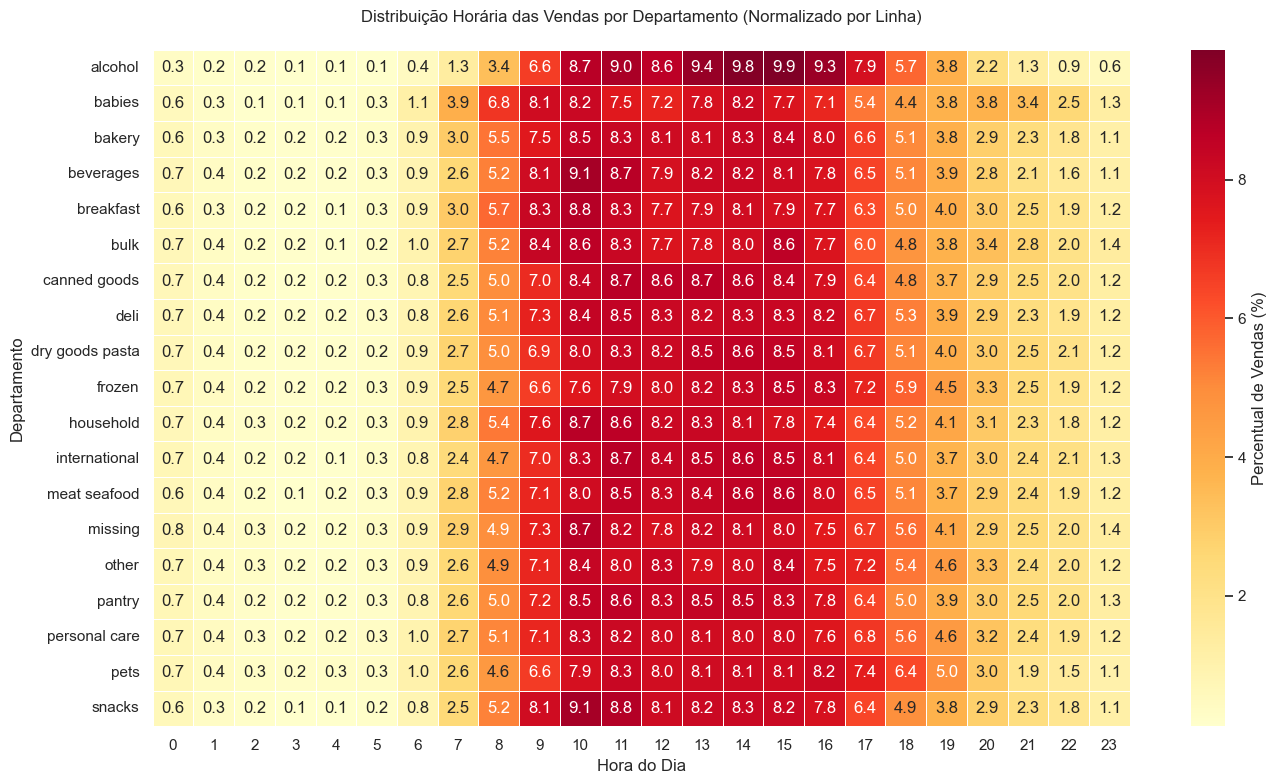

In [37]:
# 1. Agrupar os dados por departamento e hora
dist_hora_departamento = (
    base03.groupby(['department', 'order_hour_of_day'])
    .size()
    .unstack()
    .fillna(0)
)

# 2. Normalizar por LINHA (cada departamento soma 100%)
dist_normalizada = dist_hora_departamento.div(dist_hora_departamento.sum(axis=1), axis=0) * 100

# 3. Criar o heatmap
plt.figure(figsize=(14, 8))
sns.heatmap(
    dist_normalizada,
    cmap='YlOrRd',  # Escala de cores amarelo-laranja-vermelho
    annot=True,      # Mostrar valores nas células
    fmt='.1f',       # Formato com 1 decimal
    linewidths=.5,   # Linhas finas entre células
    cbar_kws={'label': 'Percentual de Vendas (%)'}
)

# 4. Ajustar o layout
plt.title('Distribuição Horária das Vendas por Departamento (Normalizado por Linha)', pad=20)
plt.xlabel('Hora do Dia')
plt.ylabel('Departamento')
plt.yticks(rotation=0)  # Manter os rótulos dos departamentos horizontais
plt.tight_layout()
plt.show()

## Salvando base de dados